In [16]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
#from torch import linspace
import os
import time
from smt.sampling_methods import LHS
#torch.set_default_dtype(torch.float64)
dtype=torch.float64

from E_data_LHS import Move_Time_1D,Pertur_1D,Euler_WENO,IC_Riemann_1D
from E_Plotting import E_plot,  loss_plot 

# Full PINN
from E_PINN_WE import PINNs_WE_Euler_1D
from E_PINN_IM_exp import PINNs_IM_Euler_1D
#from E_PINN_train_plot import pinn_train

# TGPT-PINN
#from E_TGPT_PINN import GPT
#from E_TGPT_train import gpt_train
from E_TGPT_activation import P

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

def to_numpy(input):
    if isinstance(input, torch.Tensor):
        return input.detach().cpu().numpy()
    elif isinstance(input, np.ndarray):
        return input

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
#torch.manual_seed(12)
#np.random.seed(12)
#setup_seed(7)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


In [17]:
def train(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss = loss_pde +10*(loss_ic+loss_bc) + 100*(loss_rh) +100*loss_con  
        #print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    if (epoch % 5000 == 0):
        #ind = 100
        print(f'epoch {epoch} loss:{loss:.8f}')
        plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
        plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
        plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"

        #u_pred = to_numpy(model(x_test))
        #plt.plot(x[:],torch.exp(model(x_test)[:,:1]).detach().cpu(),'--',label=fr"$Density$")
        plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,1:2]).detach().cpu(),'--',label=fr"$Pressure$")
        plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,2:]).detach().cpu(),'--',label=fr"$Velocity$")
        plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
        plt.xlabel("x",     fontsize=16)
        plt.ylabel("Solution", fontsize=16)
        plt.title(fr"$t={round(Te,3)}$")
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#
        plt.show()
    return loss

def train2(epoch):
    def closure():
        optimizer.zero_grad()                                                     
        loss_pde = model.loss_pde2(x_int)                                    
        loss_ic = model.loss_ic(x_ic, rho_ic,u_ic,p_ic)   
        loss_bc = model.loss_ic(x_bc, rho_bc,u_bc,p_bc)   
        
        loss_rh = model.loss_rh(xrh,xrhL) # RH relation
        loss_con = model.loss_con(x_en,x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR,Te-Ts) #Conservation laws
        loss = loss_pde +10*(loss_ic+loss_bc) + 100*(loss_rh) +100*loss_con  
        #print(f'epoch {epoch} loss_pde:{loss_pde:.8f}, loss_ic:{loss_ic:.8f}, loss_rh:{loss_rh:.8f},loss_con:{loss_con:.8f}')
        loss.backward()
        return loss
    loss = optimizer.step(closure)

    if (epoch % 500 == 0):
        print(f'epoch {epoch} loss:{loss:.8f}')
        plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
        plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
        plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"

        #u_pred = to_numpy(model(x_test))
        #plt.plot(x[:],torch.exp(model(x_test)[:,:1]).detach().cpu(),'--',label=fr"$Density$")
        plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,1:2]).detach().cpu(),'--',label=fr"$Pressure$")
        plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
        #plt.plot(x[:],torch.exp(model(x_test)[:,2:]).detach().cpu(),'--',label=fr"$Velocity$")
        plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
        # plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
        plt.xlabel("x",     fontsize=16)
        plt.ylabel("Solution", fontsize=16)
        plt.title(fr"$t={Te}$")
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.tick_params(axis='both', which='minor', labelsize=12)

        plt.legend(fontsize = 12)#
        plt.show()
    return loss

In [18]:
# Initial and Boundary Conditions
crhoL =1.0
cuL = 0.0
cpL = 1.0

crhoR = 0.125
cuR = 0
cpR = 0.1

ini = [crhoL,cpL,cuL,crhoR,cpR,cuR]

# Domain and Data
#Xi, Xf         =  -1.0, 2.0
Xs, Xe         =  0.0, 1.0
Ts, Te         =  0.0, 0.2

x = np.linspace(0.0, 1.0, 100)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(device)

IC_pts         =  1000
N_RH           =  1000
dx = 0.01
dt = 0.002

gamma = 1.4
number_of_neurons = 1
P_list = np.ones(number_of_neurons, dtype=object)

xlimits = np.array([[0.,Te],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_int= sampling(50000)

xlimits = np.array([[0.,0],[0, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_ic= sampling(1000)

xlimits = np.array([[0.,Te],[0, 0]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcL= sampling(100)
xlimits = np.array([[0.,Te],[Xe, Xe]])  #interal
sampling = LHS(xlimits=xlimits)
x_bcR= sampling(1000)
x_bc = np.vstack((x_bcL,x_bcR))

rho_ic, u_ic, p_ic= IC_Riemann_1D(x_ic,crhoL,cuL,cpL,crhoR,cuR,cpR)                    
rho_bc, u_bc, p_bc= IC_Riemann_1D(x_bc,crhoL,cuL,cpL,crhoR,cuR,cpR)     

xrh,xrhL,xrhR,xrhP,xrhPL,xrhPR = Pertur_1D(x_ic,Te,dt,dx)

x_en = Move_Time_1D(x_ic,Te)

x_ic = torch.tensor(x_ic,dtype=dtype).to(device)
x_bc = torch.tensor(x_bc,dtype=dtype).to(device)
x_int = torch.tensor(x_int,requires_grad=True, dtype=dtype).to(device)
x_en = torch.tensor(x_en,  dtype=dtype).to(device)
xrh = torch.tensor(xrh,  dtype=dtype).to(device)
xrhL = torch.tensor(xrhL,  dtype=dtype).to(device)

rho_ic = torch.tensor(rho_ic, dtype=dtype).to(device)
u_ic = torch.tensor(u_ic, dtype=dtype).to(device)
p_ic = torch.tensor(p_ic, dtype=dtype).to(device)

rho_bc = torch.tensor(rho_bc, dtype=dtype).to(device)
u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
p_bc = torch.tensor(p_bc, dtype=dtype).to(device)

#from E_data_LHS import Euler_WENO
#weno_u = Euler_WENO(Xs,Xe,Ts,Te,ini,gamma,delta_t=0.0001,delta_x=0.005)

from E_solver import exact_solver
Rie_u = exact_solver([crhoL,cuL,cpL],[crhoR,cuR,cpR],gamma,Te,N=200)

In [19]:
lr_pinn     = 0.001
epochs_pinn = [25000,20000,20000,25000]
#layers_pinn = np.array([2, 60, 60,60,60,60, 3])
#layers_pinn = np.array([2, 120, 120,120, 3])
layers_pinn = np.array([2, 50, 50,50, 50, 50,50, 3])
tol         = 1e-2

Start training...
loss_tot:0.19864947,lr:0.001
epoch 5000 loss:0.06433748


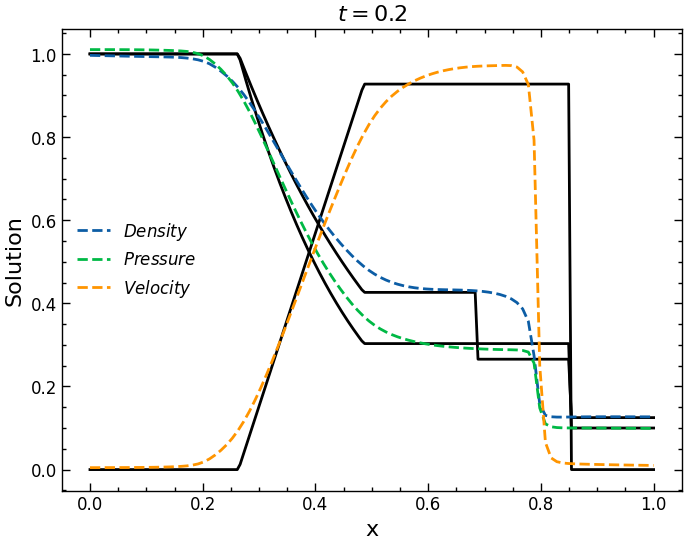

loss_tot:0.00999355,lr:0.0001
epoch 10000 loss:0.00908016


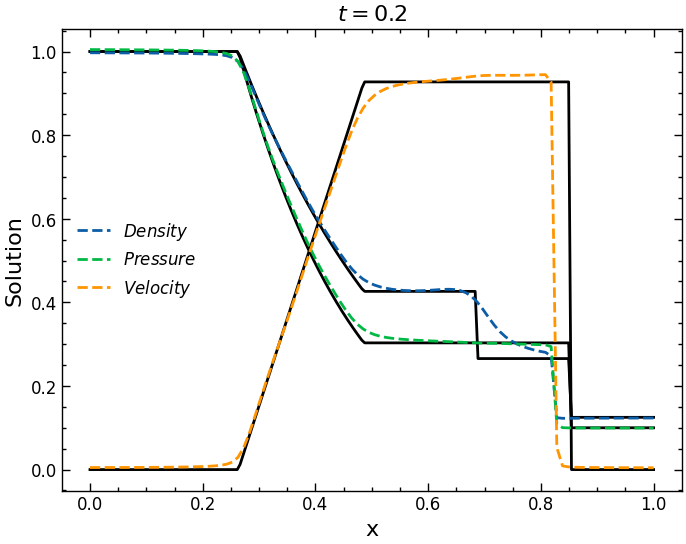

epoch 15000 loss:0.02509704


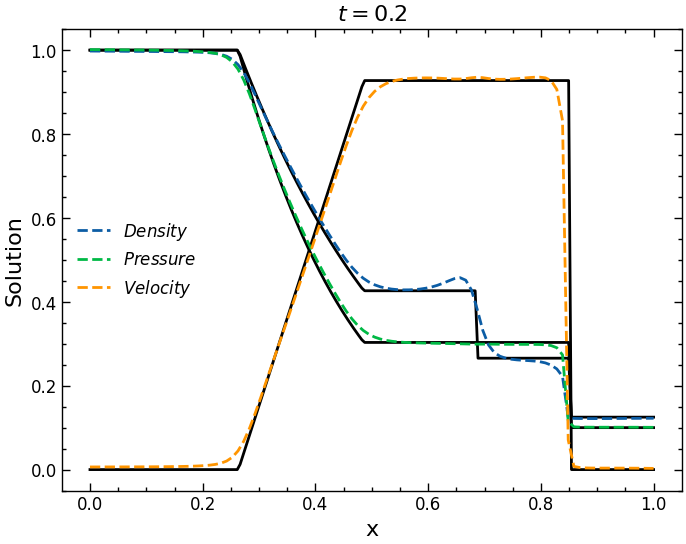

epoch 20000 loss:0.01095672


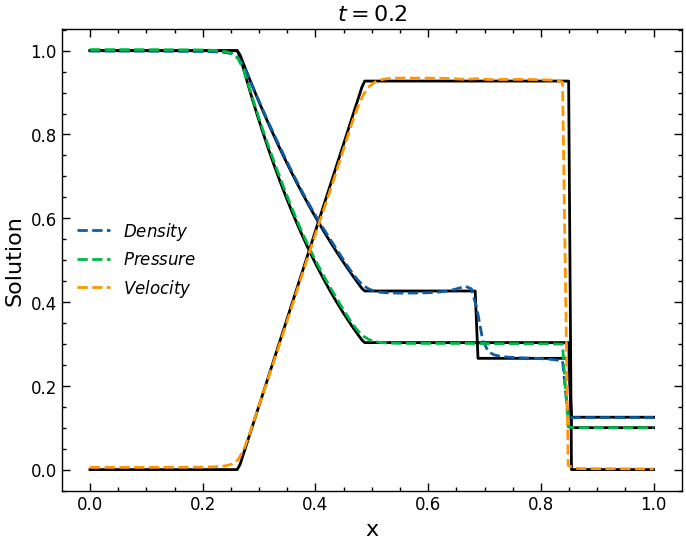

epoch 25000 loss:0.02846490


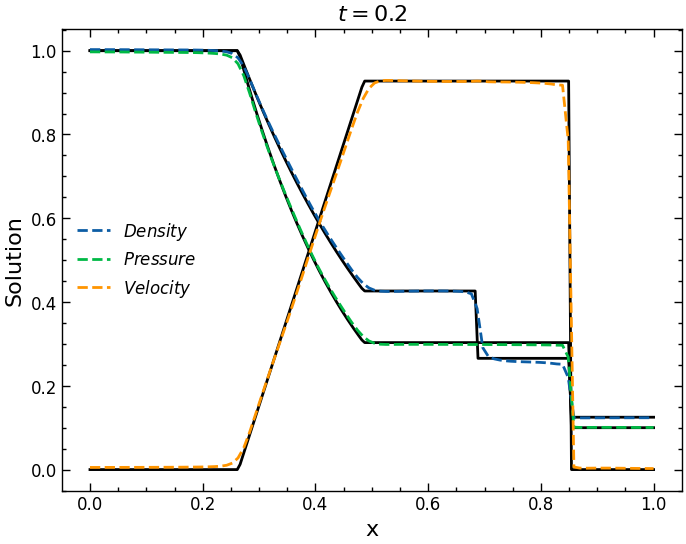

Total training time: 557.6471078395844


In [20]:
model =  PINNs_IM_Euler_1D(Nl=7,Nn=50).to(device).double()
print('Start training...')
ind = 0
epoch = 0
epochi = epoch
lr = 0.001                                                         # Learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 50000
loss_history=[]
tic = time.time()

for epoch in range(1+epochi, epochs+epochi):
    loss = train(epoch)
    #print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
    if loss < 0.2 and ind ==0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
        ind =1
        print(f'loss_tot:{loss:.8f},lr:0.001')
    if loss < 0.01 and ind ==1:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
        ind =2
        print(f'loss_tot:{loss:.8f},lr:0.0001')
    if loss >10 and ind >0:
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        ind = 0
        print(f'loss_tot:{loss:.8f},lr:0.005')
    if loss <0.005:
        break
toc = time.time()
print(f'Total training time: {toc - tic}')

epoch 0 loss:0.00499135


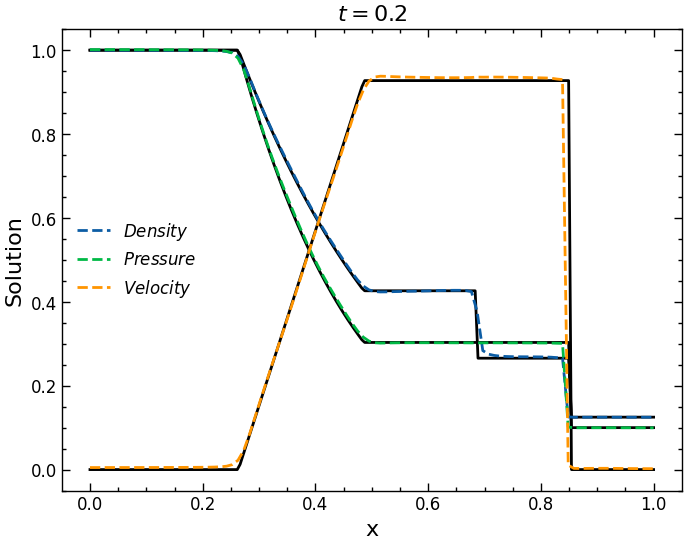

loss_tot:0.00499135
loss_tot:0.00506841
loss_tot:0.00503176
loss_tot:0.00500717
loss_tot:0.00499064
loss_tot:0.00497953
loss_tot:0.00497203
loss_tot:0.00496697
loss_tot:0.00496353
loss_tot:0.00496116
loss_tot:0.00495952
loss_tot:0.00495834
loss_tot:0.00495745
loss_tot:0.00495671
loss_tot:0.00495602
loss_tot:0.00495524
loss_tot:0.00495417
loss_tot:0.00495249
loss_tot:0.00494929
loss_tot:0.00494340
loss_tot:0.00492988
loss_tot:0.00490295
loss_tot:0.00487018
loss_tot:0.00483207
loss_tot:0.00478635
loss_tot:0.00473985
loss_tot:0.00469810
loss_tot:0.00465202
loss_tot:0.00460293
loss_tot:0.00455582
loss_tot:0.00451183
loss_tot:0.00446442
loss_tot:0.00441896
loss_tot:0.00436256
loss_tot:0.00430179
loss_tot:0.00423037
loss_tot:0.00415879
loss_tot:0.00409677
loss_tot:0.00404416
loss_tot:0.00399901
loss_tot:0.00396164
loss_tot:0.00392652
loss_tot:0.00388787
loss_tot:0.00384498
loss_tot:0.00380143
loss_tot:0.00375672
loss_tot:0.00371544
loss_tot:0.00368127
loss_tot:0.00364958
loss_tot:0.00361660


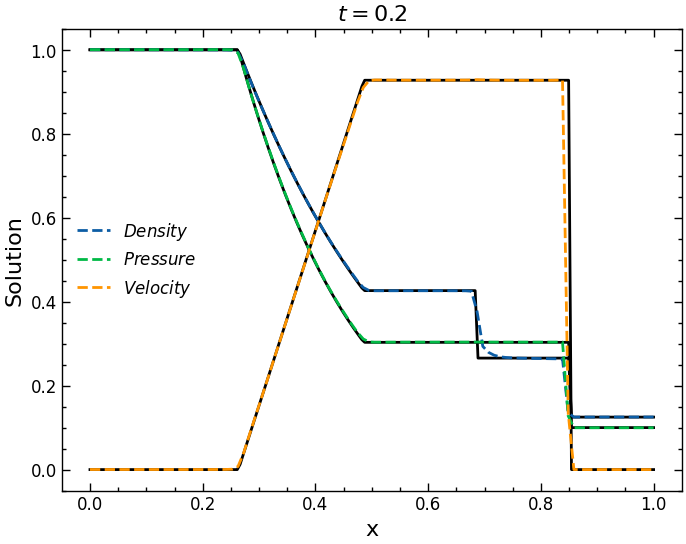

loss_tot:0.00105236
loss_tot:0.00105069
loss_tot:0.00104899
loss_tot:0.00104715
loss_tot:0.00104530
loss_tot:0.00104345
loss_tot:0.00104141
loss_tot:0.00103910
loss_tot:0.00103681
loss_tot:0.00103453
loss_tot:0.00103224
loss_tot:0.00103006
loss_tot:0.00102806
loss_tot:0.00102628
loss_tot:0.00102469
loss_tot:0.00102330
loss_tot:0.00102201
loss_tot:0.00102067
loss_tot:0.00101931
loss_tot:0.00101798
loss_tot:0.00101648
loss_tot:0.00101480
loss_tot:0.00101312
loss_tot:0.00101153
loss_tot:0.00101010
loss_tot:0.00100870
loss_tot:0.00100737
loss_tot:0.00100603
loss_tot:0.00100461
loss_tot:0.00100317
loss_tot:0.00100174
loss_tot:0.00100033
loss_tot:0.00099889
loss_tot:0.00099745
loss_tot:0.00099601
loss_tot:0.00099428
loss_tot:0.00099234
loss_tot:0.00099039
loss_tot:0.00098871
loss_tot:0.00098718
loss_tot:0.00098499
loss_tot:0.00098201
loss_tot:0.00097899
loss_tot:0.00097648
loss_tot:0.00097451
loss_tot:0.00097291
loss_tot:0.00097145
loss_tot:0.00097006
loss_tot:0.00096872
loss_tot:0.00096743


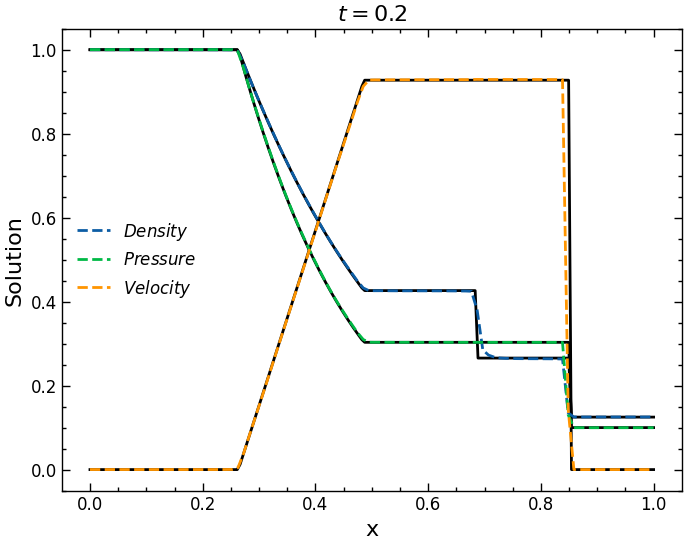

loss_tot:0.00048204
loss_tot:0.00048169
loss_tot:0.00048128
loss_tot:0.00048084
loss_tot:0.00048040
loss_tot:0.00047995
loss_tot:0.00047950
loss_tot:0.00047901
loss_tot:0.00047845
loss_tot:0.00047780
loss_tot:0.00047712
loss_tot:0.00047648
loss_tot:0.00047590
loss_tot:0.00047537
loss_tot:0.00047488
loss_tot:0.00047443
loss_tot:0.00047404
loss_tot:0.00047373
loss_tot:0.00047343
loss_tot:0.00047301
loss_tot:0.00047241
loss_tot:0.00047172
loss_tot:0.00047105
loss_tot:0.00047044
loss_tot:0.00046993
loss_tot:0.00046950
loss_tot:0.00046911
loss_tot:0.00046875
loss_tot:0.00046841
loss_tot:0.00046797
loss_tot:0.00046738
loss_tot:0.00046669
loss_tot:0.00046599
loss_tot:0.00046533
loss_tot:0.00046475
loss_tot:0.00046411
loss_tot:0.00046339
loss_tot:0.00046257
loss_tot:0.00046167
loss_tot:0.00046088
loss_tot:0.00046015
loss_tot:0.00045952
loss_tot:0.00045897
loss_tot:0.00045845
loss_tot:0.00045801
loss_tot:0.00045760
loss_tot:0.00045717
loss_tot:0.00045670
loss_tot:0.00045616
loss_tot:0.00045550


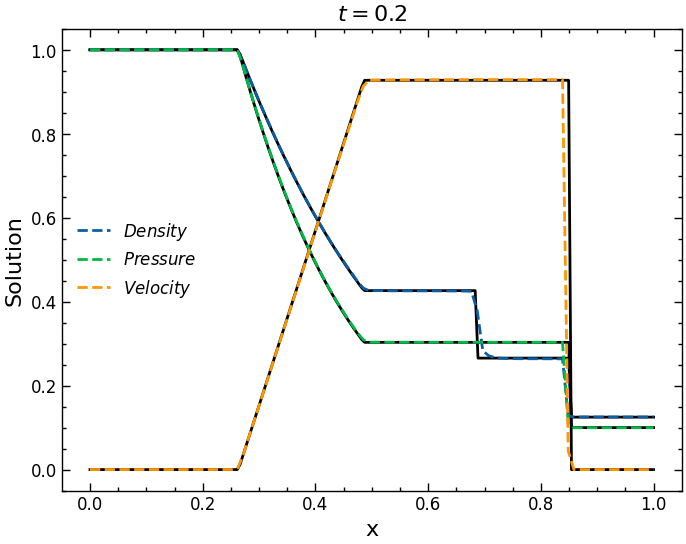

loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915
loss_tot:0.00042915


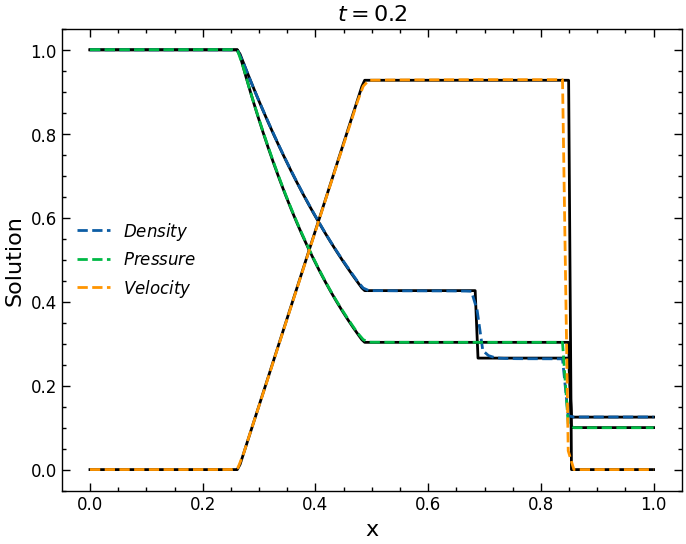

loss_tot:0.00042912
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911
loss_tot:0.00042911


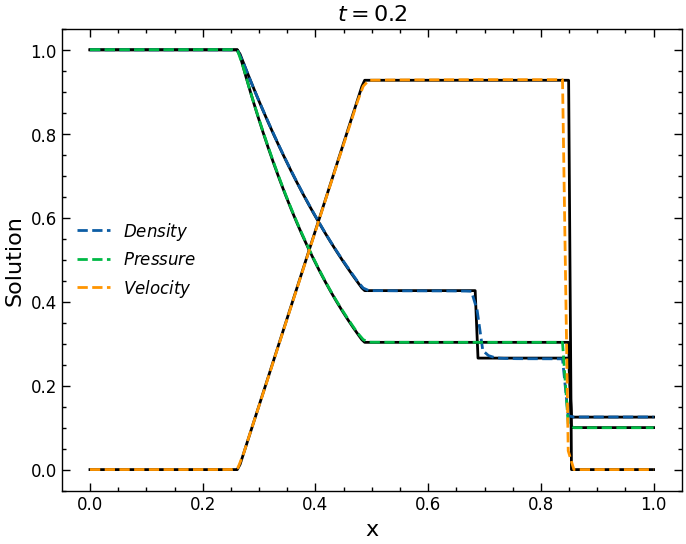

loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908
loss_tot:0.00042908


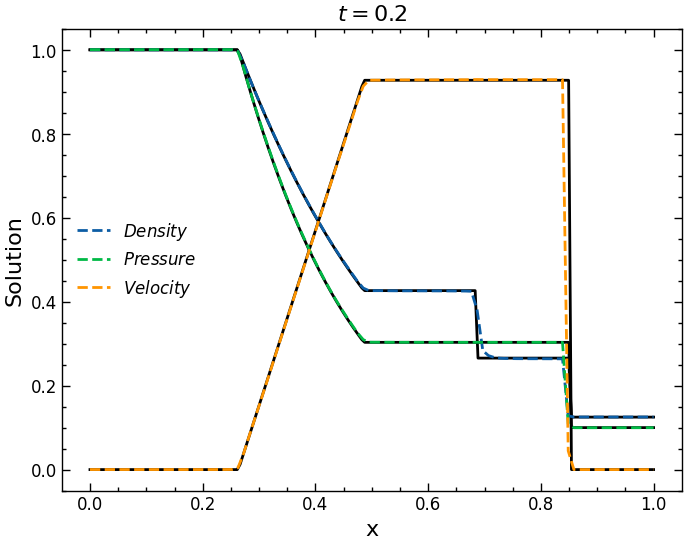

loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042905
loss_tot:0.00042904
loss_tot:0.00042904
loss_tot:0.00042904
loss_tot:0.00042904


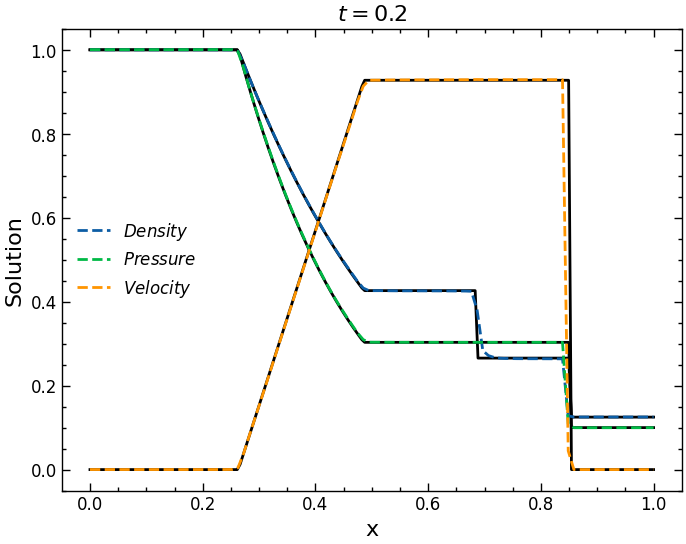

loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042902
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901
loss_tot:0.00042901


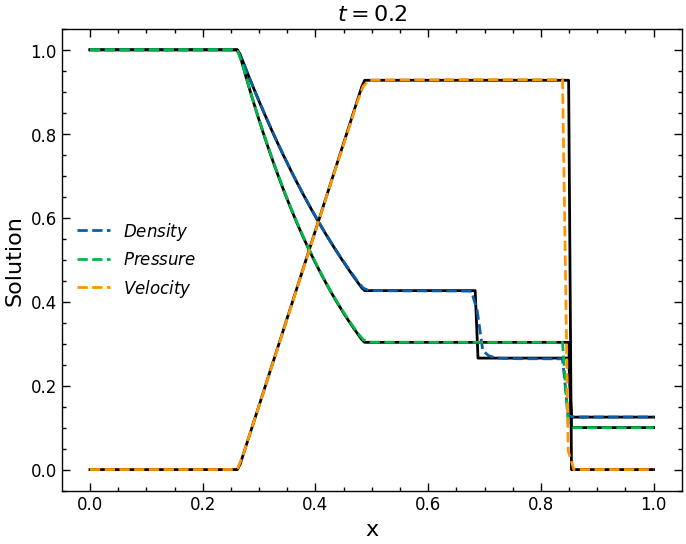

loss_tot:0.00042899
loss_tot:0.00042899
loss_tot:0.00042899
loss_tot:0.00042899
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898
loss_tot:0.00042898


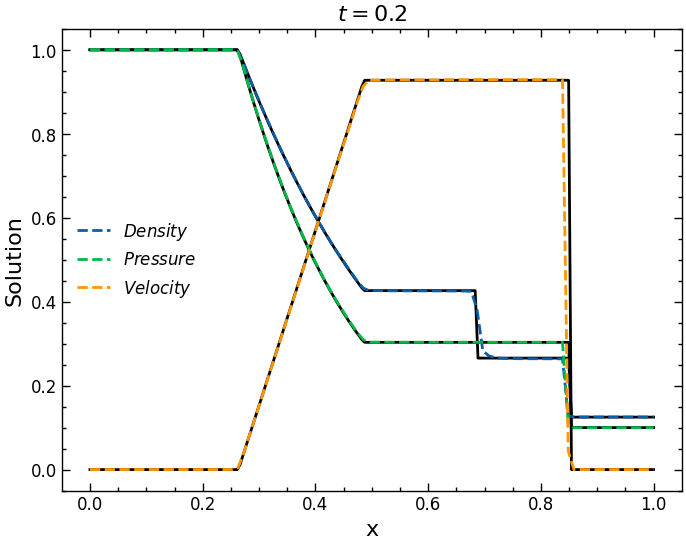

loss_tot:0.00042896
loss_tot:0.00042896
loss_tot:0.00042896
loss_tot:0.00042896
loss_tot:0.00042896
loss_tot:0.00042896
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895
loss_tot:0.00042895


In [21]:
optimizer = torch.optim.LBFGS(model.parameters(),lr=0.01,max_iter=20)
epochi = 0
epochs = 5000
tic = time.time()
for epoch in range(epochi, epochs+epochi):
    loss = train2(epoch)
    print(f'loss_tot:{loss:.8f}')
    loss_history.append(to_numpy(loss))
  #  if loss < 0.005:
   #     break
toc = time.time()

print(f'Total training time: {toc - tic}')

In [22]:
print({stop})

NameError: name 'stop' is not defined

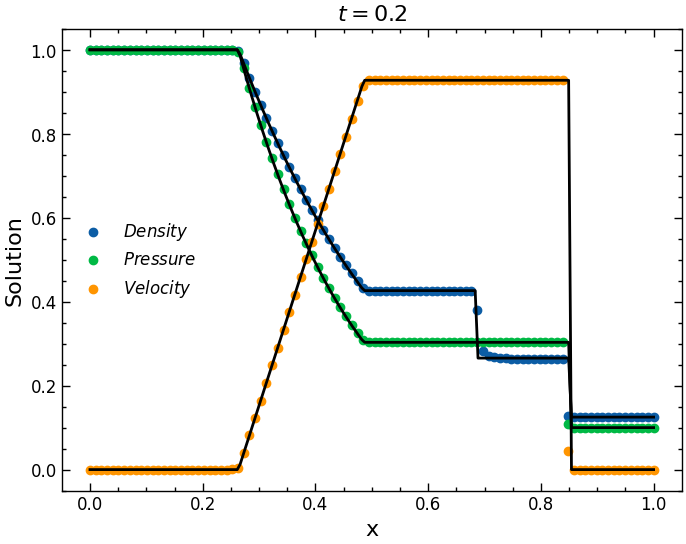

In [23]:
plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"


#plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
plt.scatter(x[:],model(x_test)[:,:1].detach().cpu(),label=fr"$Density$")
#plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
plt.scatter(x[:],model(x_test)[:,1:2].detach().cpu(),label=fr"$Pressure$")
#plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
plt.scatter(x[:],model(x_test)[:,2:].detach().cpu(),label=fr"$Velocity$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("Solution", fontsize=16)
plt.title(fr"$t={Te}$")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

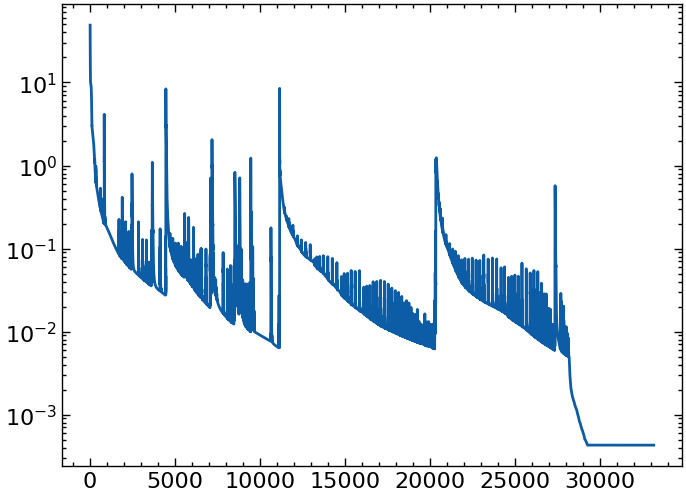

In [24]:
plt.plot(loss_history)
plt.yscale('log')

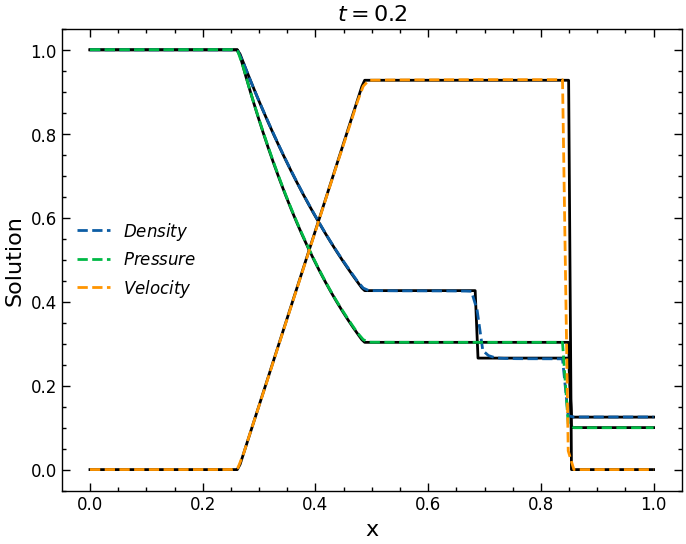

In [25]:
#from E_data_LHS import Euler_WENO
#weno_u = Euler_WENO(Xs,Xe,Ts,Te,ini,gamma,delta_t=0.0001,delta_x=0.005)

ind = 100
plt.plot(Rie_u[3],Rie_u[0],'k')#,label="$Density$"
plt.plot(Rie_u[3],Rie_u[1],'k')#,label="$Pressure$"
plt.plot(Rie_u[3],Rie_u[2],'k')#,label="$velocity$"

Nt_test = 100
x = np.linspace(0.0, 1.0, Nt_test)                                   
t = np.linspace(Te, Te, 1)                                     
t_grid, x_grid = np.meshgrid(t, x)                               
T = t_grid.flatten()[:, None]                                    
X = x_grid.flatten()[:, None]                                    
x_test = np.hstack((T, X))                                       
x_test = torch.tensor(x_test, dtype=dtype).to(device)
#u_pred = to_numpy(model(x_test))
#plt.plot(x[:],torch.exp(model(x_test)[:,:1]).detach().cpu(),'--',label=fr"$Density$")
#plt.plot(x[:],torch.exp(model(x_test)[:,1:2]).detach().cpu(),'--',label=fr"$Pressure$")
#plt.plot(x[:],torch.exp(model(x_test)[:,2:]).detach().cpu(),'--',label=fr"$Velocity$")
plt.plot(x[:],model(x_test)[:,:1].detach().cpu(),'--',label=fr"$Density$")
plt.plot(x[:],model(x_test)[:,1:2].detach().cpu(),'--',label=fr"$Pressure$")
plt.plot(x[:],model(x_test)[:,2:].detach().cpu(),'--',label=fr"$Velocity$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[0][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Density$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[1][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Pressure$")
# plt.plot(xt_test[0::Nt_test,1].detach().cpu(),PINN(xt_test)[2][ind-1::Nx_test].detach().cpu(),'--',label=fr"$Velocity$")
plt.xlabel("x",     fontsize=16)
plt.ylabel("Solution", fontsize=16)
plt.title(fr"$t={round((ind-1)*(Te-Ts)/(Nt_test-1),3)}$")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

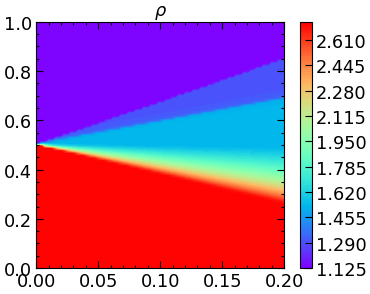

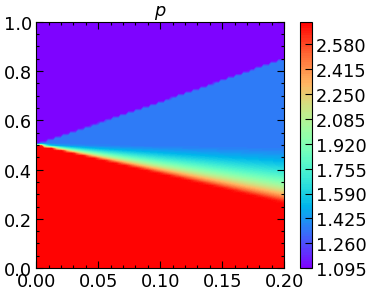

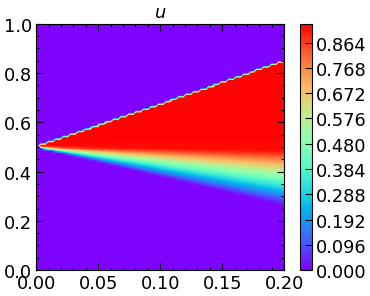

In [26]:
from E_data import create_residual_data
xt_test = create_residual_data(Xs, Xe, Ts, Te, 100,100,100,100,10000)[2].to(device) 

E_plot(xt_test, torch.exp(model(xt_test)[:,:1]), dpi=80, figsize=(5,4),title=fr"$\rho$")
E_plot(xt_test, torch.exp(model(xt_test)[:,1:2]), dpi=80, figsize=(5,4),title=fr"$p$")
E_plot(xt_test, model(xt_test)[:,2:], dpi=80, figsize=(5,4),title=fr"$u$")

In [31]:
from E_TGPT_activation import P
layers_pinn = np.array([2, 50, 50,50, 50, 50,50, 3])

w1 = model.net.Linear_layer_1.weight.detach().cpu()
w2 = model.net.Linear_layer_2.weight.detach().cpu()
w3 = model.net.Linear_layer_3.weight.detach().cpu()
w4 = model.net.Linear_layer_4.weight.detach().cpu()
w5 = model.net.Linear_layer_5.weight.detach().cpu()
w6 = model.net.Linear_layer_6.weight.detach().cpu()
w7 = model.net.Linear_layer_final.weight.detach().cpu()


b1 = model.net.Linear_layer_1.bias.detach().cpu()
b2 = model.net.Linear_layer_2.bias.detach().cpu()
b3 = model.net.Linear_layer_3.bias.detach().cpu()
b4 = model.net.Linear_layer_4.bias.detach().cpu()
b5 = model.net.Linear_layer_5.bias.detach().cpu()
b6 = model.net.Linear_layer_6.bias.detach().cpu()
b7 = model.net.Linear_layer_final.bias.detach().cpu()


# Add new activation functions
P_list = P(layers_pinn, w1, w2, w3, w4, w5,w6,w7, b1, b2, b3, b4,b5,b6,b7).to(device)

import pickle 
with open('PINN_sod_p10.pkl', 'wb') as f:
    pickle.dump(P_list, f)

In [32]:
np.save('loss_history_p10.npy', np.array(loss_history)) 
#loss_history = np.load('loss_history_p10.npy')